**LIME**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16 # type: ignore
from tensorflow.keras.preprocessing import image # type: ignore
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

In [2]:
model = VGG16(weights='imagenet') 

553467096/553467096 [==============================] - 105s 0us/step


In [4]:
img = image.load_img('cat.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)

In [5]:
preds = model.predict(x)
predicted_class = np.argmax(preds[0])

1/1 [==============================] - 0s 455ms/step


In [9]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.squeeze(x), model.predict, top_labels=1, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


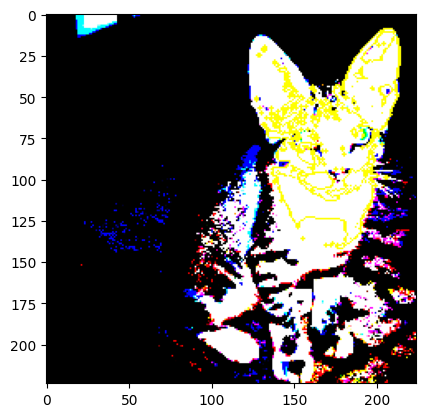

In [10]:
temp, mask = explanation.get_image_and_mask(predicted_class, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

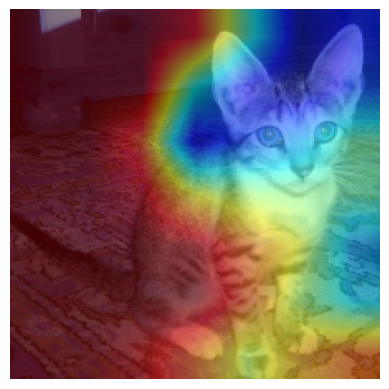

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load a pre-trained model (ResNet)
model = models.resnet50(pretrained=True)
model.eval()

# Hook the gradients of the last convolutional layer
class SaveFeatures:
    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output):
        self.features = output
    
    def close(self):
        self.hook.remove()

class SaveGradients:
    def __init__(self, layer):
        self.hook = layer.register_backward_hook(self.hook_fn)
        
    def hook_fn(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]
        
    def close(self):
        self.hook.remove()

# Function to preprocess the image
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor

# Function to apply Grad-CAM
def apply_gradcam(img_path, model, target_class=None, alpha=0.5):
    img_tensor = preprocess_image(img_path)
    
    # Get the final convolutional layer
    final_conv_layer = model.layer4[2].conv3
    
    # Hook to save the features and gradients
    features = SaveFeatures(final_conv_layer)
    gradients = SaveGradients(final_conv_layer)
    
    # Forward pass
    output = model(img_tensor)
    if target_class is None:
        target_class = output.argmax().item()
    
    # Zero the gradients and calculate gradients w.r.t the target class
    model.zero_grad()
    class_loss = output[:, target_class]
    class_loss.backward()
    
    # Get the gradients and feature maps
    gradient = gradients.gradients.data.numpy()[0]
    activation = features.features.data.numpy()[0]
    
    # Compute the Grad-CAM heatmap
    weights = np.mean(gradient, axis=(1, 2))  # Global average pooling
    grad_cam = np.zeros(activation.shape[1:], dtype=np.float32)
    
    for i, w in enumerate(weights):
        grad_cam += w * activation[i]
    
    grad_cam = np.maximum(grad_cam, 0)  # ReLU activation
    grad_cam = cv2.resize(grad_cam, (224, 224))
    grad_cam -= grad_cam.min()
    grad_cam /= grad_cam.max()
    
    # Plot the heatmap with better transparency
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap * alpha + np.float32(img) / 255 * (1 - alpha)
    overlay = overlay / np.max(overlay)
    
    # Display the result
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()
image_path = 'train/cat.7.jpg'
# Usage with an optional transparency (alpha) value
apply_gradcam(image_path, model, alpha=0.5)